In [1]:
# Generales
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot as pyd
import time
import joblib

# image preprocessing
import os
import sys
import shutil
import glob
import matplotlib.image as mpimg
from PIL import Image

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#keras
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization

# keras utils
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model

#keras resnet_50_v2
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input

# tensorflow
import tensorflow as tf
from tensorflow.random import set_seed

#cv2
import cv2
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%env name=samples1_512_4VR
!echo $name

env: name=samples1_512_4VR
samples1_512_4VR


In [4]:
# copy samples file to directory
!cp ./drive/Shareddrives/Memoria/samples/$name.zip ./$name.zip

!unzip -o -q $name.zip -d ./samples

In [5]:
set_seed(42)
np.random.seed(42)

In [6]:
# Constants

# dirs
inp_img_dir = "./samples/"
out_dir = ""

# init
start_num = 1

height, width = 32, 32

# placeholder
r = "rule_"

# all file names and classes
files = {'1':[], '2':[], '3':[], '4':[]}

# Classes
class1 = [0, 8, 32, 40, 128, 136, 160, 168]
class2 = [
          1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 19,
          23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38,
          42, 43, 44, 46, 50, 51, 56, 57, 58, 62, 72, 73, 74,
          76, 77, 78, 94, 104, 108, 130, 132, 134, 138, 140,
          142, 152, 154, 156, 162, 164, 170, 172, 178, 184,
          200, 204, 232
        ]
class3 = [18, 22, 30, 45, 60, 90, 105, 122, 126, 146, 150]
class4 = [41, 54, 106, 110]

## Dataset Generation

In [7]:
def getPics(classRules, samplesDir):
    classImgs = []

    for r in classRules:
        imgsDir = samplesDir + f'rule_{str(r)}/'
        classImgs += [imgsDir + f for f in os.listdir(imgsDir)]
    return classImgs


c1_img_list = getPics(class1 + class2 + class3, inp_img_dir)
c4_img_list = getPics(class4, inp_img_dir)

## Data Prep

In [8]:
len(c1_img_list), len(c4_img_list)

(21504, 21486)

In [9]:
files_target = [np.full(len(c1_img_list), '1', dtype=str),
                np.full(len(c4_img_list), '4', dtype=str), ]
[x.shape[0] for x in files_target]

[21504, 21486]

In [10]:
# Data selection

c1_x = c1_img_list.copy()
c4_x = c4_img_list.copy()

c1_y = files_target[0].copy()
c4_y = files_target[1].copy()

In [11]:
c_x = np.array(c1_x + c4_x)
c_y = np.concatenate((c1_y, c4_y))

In [12]:
dataset = pd.DataFrame({'img':c_x, 'class':c_y})
dataset = dataset.sample(frac=1)
dataset

,img,class
41571,./samples/rule_110/110_000_0166_1908.png,4
5545,./samples/rule_15/15_000_0240_1718.png,1
42129,./samples/rule_110/110_000_0076_2500.png,4
22790,./samples/rule_41/41_000_0062_964.png,4
38118,./samples/rule_110/110_000_0022_8437.png,4
...,...,...
6265,./samples/rule_24/24_000_0230_8183.png,1
11284,./samples/rule_58/58_000_0138_6445.png,1
38158,./samples/rule_110/110_000_0237_6553.png,4
860,./samples/rule_40/40_000_0254_4772.png,1


## Data Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dataset['img'].values, dataset['class'].values, test_size=0.33, random_state=42)

# Reshape

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# one hot encoding
enc = OneHotEncoder(sparse=False)
enc.fit(y_train)

# save encode
joblib.dump(enc, './drive/Shareddrives/Memoria/encodings/encoder' + 'resnet_V2_4vr' + '.joblib')

# transform data
y_train = enc.transform(y_train)

# print(pd.DataFrame(y_train, columns=list(enc.categories_[0])).head())

# tranform encoding for test data
y_test = enc.transform(y_test)
# to print the encoded features for train data
print(pd.DataFrame(y_test, columns=list(enc.categories_[0])).head())

     1    4
0  1.0  0.0
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
X_train[0], y_train[0]

('./samples/rule_25/25_000_0026_8471.png', array([1., 0.]))

## Images

In [15]:
def getImages(files):
    img_list = []

    for img in files:
        img1 = load_img(out_dir + img, color_mode='rgb')
        x = img_to_array(img1) / 255

        img_list.append(x)

    return np.array(img_list)

In [16]:
# Images Preview
def imagePreview(imgsArr):
    imgs_show = [imgsArr[0], imgsArr[50], imgsArr[2589], imgsArr[-4]]
    plt.figure(figsize=(16,8))
    columns = 4

    for i, image in enumerate(imgs_show):
        plt.subplot(len(imgs_show) // columns + 1, columns, i + 1)

        plt.imshow(array_to_img(image))

    plt.figure()
    plt.show()

In [17]:
X_train = getImages(X_train)

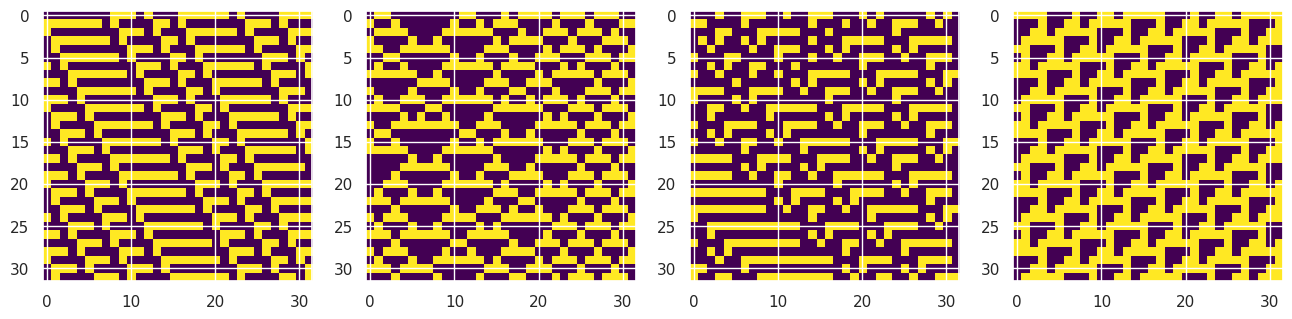

<Figure size 640x480 with 0 Axes>

In [18]:
imagePreview(X_train)

In [19]:
X_test = getImages(X_test)

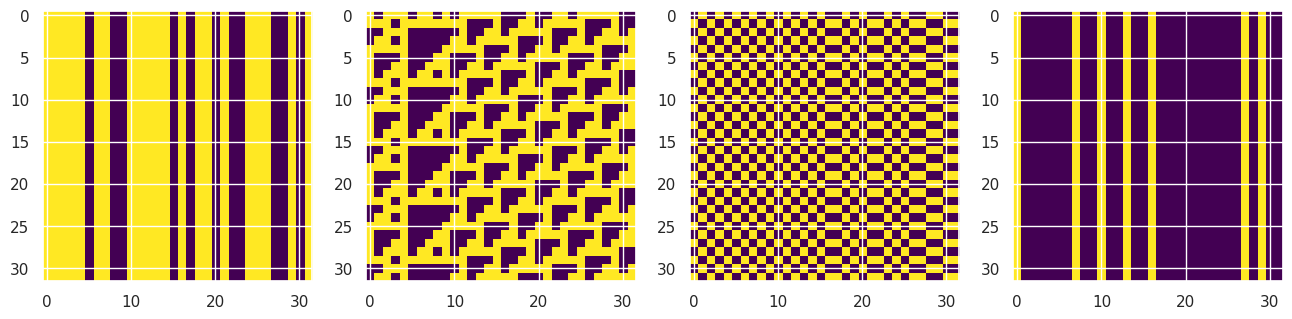

<Figure size 640x480 with 0 Axes>

In [20]:
imagePreview(X_test)

In [21]:
X_train[0].shape

(32, 32, 3)

## Training

In [22]:
# parameters
kernel = 3
stride = 2

# input
input_shape = (height, width, 3)

res = ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)
# Make all layers untrainable
for layer in res.layers[:]:
    layer.trainable = False

output = res.get_layer('conv3_block3_preact_bn').output
output = Flatten(name='new_flatten')(output)
output = Dense(1024, activation='relu', name='new_fc')(output)
output = Dense(2, activation='softmax')(output)
res = Model(res.input, output)


res.get_layer('new_fc').trainable = True

94668760/94668760 [==============================] - 1s 0us/step


In [23]:
# Model
save_dir = './drive/Shareddrives/Memoria/code/best_models/resnet_V2_4vr_best.h5'

# 1e-2
opt = Adam(learning_rate=1e-2, amsgrad=True)
met = tf.keras.metrics.CategoricalAccuracy()

res.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=[met]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir,
                            monitor='val_categorical_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='max',
                                      verbose=1,
                                      patience=15)

callbacks_list = [checkpoint, es]

hist = res.fit(
    x = X_train,
    y = y_train,
    validation_data=([X_test], y_test),
    # ep 50, b 12
    epochs=100,
    batch_size=12,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/100
2401/2401 [==============================] - ETA: 0s - loss: 1.2171 - categorical_accuracy: 0.9577
Epoch 1: val_categorical_accuracy improved from -inf to 0.96814, saving model to ./drive/Shareddrives/Memoria/code/best_models/resnet_V2_4vr_best.h5
2401/2401 [==============================] - 37s 11ms/step - loss: 1.2171 - categorical_accuracy: 0.9577 - val_loss: 0.1157 - val_categorical_accuracy: 0.9681
Epoch 2/100
2395/2401 [============================>.] - ETA: 0s - loss: 0.0397 - categorical_accuracy: 0.9888
Epoch 2: val_categorical_accuracy improved from 0.96814 to 0.99641, saving model to ./drive/Shareddrives/Memoria/code/best_models/resnet_V2_4vr_best.h5
2401/2401 [==============================] - 22s 9ms/step - loss: 0.0396 - categorical_accuracy: 0.9888 - val_loss: 0.0107 - val_categorical_accuracy: 0.9964
Epoch 3/100
2400/2401 [============================>.] - ETA: 0s - loss: 0.0193 - categorical_accuracy: 0.9951
Epoch 3: val_categorical_accuracy did not improve

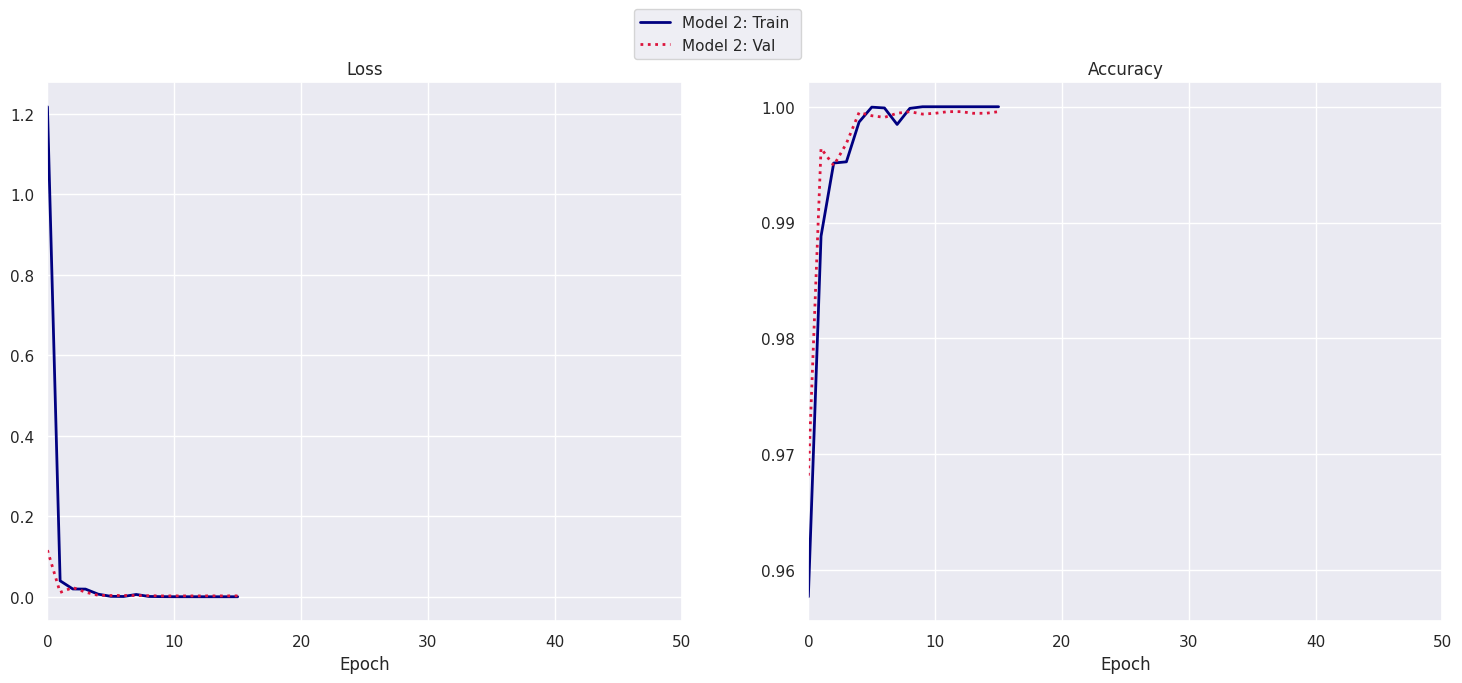

In [24]:
fig = plt.figure(figsize=(18, 7), facecolor='w', edgecolor='k')
gs  = gridspec.GridSpec(nrows=1, ncols=2)
ax = plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1])

colors_list = ["crimson", "orchid", "navy", "aqua"]

num=2
l1 = ax[0].plot(hist.history['loss'], c=colors_list[num] ,label='Model '+str(num)+': Train ', linewidth=2)
ax[0].plot(hist.history['val_loss'], ls='dotted', c=colors_list[0], label='Model '+str(num)+': Val', linewidth=2)

ax[1].plot(hist.history['categorical_accuracy'], c=l1[0].get_color(), linewidth=2)
ax[1].plot(hist.history['val_categorical_accuracy'], ls='dotted', c=colors_list[0], linewidth=2)

# labels
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_xlim([0, 50])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_xlim([0, 50])

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(labels, loc="best", bbox_to_anchor=(0, 1.15))
plt.show()